In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

### Summary of (refined) streamlined approach

1. Loading (partial) user dataset - taking all datasets except socialbots1
2. Data preprocessing - including previously identified 5 important features
3. PCA to reduce dimensions of output dataset
4. Modelling with XGBoost/Random Forest/Logistic Regression

In [6]:
path = '/Users/harrychang/DSA4263/data/UsersData/combined_data_partial.csv'
df = pd.read_csv(path)
df

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,url,lang,...,description,contributors_enabled,following,created_at,timestamp,crawled_at,updated,test_set_1,test_set_2,Type
0,1672188043,Tori Borgna,tori_borgna,18819,792,678,4432,3,NaN,en,...,15,NaN,NaN,Thu Aug 15 04:00:09 +0000 2013,2013-08-15 06:00:09,2015-05-01 13:06:09,2016-03-15 16:10:33,0.0,0.0,Genuine
1,23258655,TMJ-SDF IT-Java Jobs,tmj_sdf_itjava,3,194,181,0,4,https://t.co/DByWt45HZj,en,...,Follow this account for geo-targeted Software ...,NaN,NaN,Sun Mar 08 01:07:02 +0000 2009,2009-03-08 02:07:02,2016-03-15 13:49:02,2016-03-15 13:49:02,NaN,NaN,Bot
2,2358855799,Ruthe Natoli,RutheNatoli,36,2,40,0,0,NaN,en,...,NaN,NaN,NaN,Mon Feb 24 02:58:14 +0000 2014,2014-02-24 03:58:14,2014-05-05 00:21:59,2016-03-15 15:16:27,NaN,NaN,Bot
3,465280740,PP,PrestonParker24,6389,1135,1763,4334,1,http://t.co/7d1AStDQWI,en,...,Snapchat - PrestonParker24 #GeauxTigersCK^2,NaN,NaN,Mon Jan 16 05:21:30 +0000 2012,2012-01-16 06:21:30,2015-05-02 11:47:10,2016-03-15 15:59:35,0.0,0.0,Genuine
4,334825381,Jackson Browne,jacksonbrowne1,11916,1006,1196,1,3,http://t.co/VXHy8Gk71k,en,...,http://t.co/VXHy8Gk71k features all of your fa...,NaN,NaN,Wed Jul 13 18:40:53 +0000 2011,2011-07-13 20:40:53,2014-05-05 23:11:04,2016-03-15 15:40:45,NaN,1.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10021,2358858643,Olga Angst,OlgaAngst,70,9,45,0,0,NaN,en,...,NaN,NaN,NaN,Mon Feb 24 03:01:06 +0000 2014,2014-02-24 04:01:06,2014-05-05 00:21:37,2016-03-15 15:14:16,NaN,NaN,Bot
10022,2367839875,Clarisa Milman,ClarisaMilman,55,1,36,0,1,NaN,en,...,NaN,NaN,NaN,Sun Mar 02 00:08:03 +0000 2014,2014-03-02 01:08:03,2014-05-05 00:21:11,2016-03-15 15:11:22,NaN,NaN,Bot
10023,2360768712,Esther Schiebel,EstherSchiebel,47,12,40,0,0,NaN,en,...,NaN,NaN,NaN,Tue Feb 25 08:52:46 +0000 2014,2014-02-25 09:52:46,2014-05-05 00:21:22,2016-03-15 15:12:26,NaN,NaN,Bot
10024,233444535,LaRosa,LaRosa_N,373,39,133,6,1,NaN,en,...,Just someone with an inquiring mind.,NaN,NaN,Mon Jan 03 07:11:54 +0000 2011,2011-01-03 08:11:54,2015-05-01 16:06:44,2016-03-15 15:58:07,1.0,0.0,Genuine


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10026 entries, 0 to 10025
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10026 non-null  int64  
 1   name                                10025 non-null  object 
 2   screen_name                         10026 non-null  object 
 3   statuses_count                      10026 non-null  int64  
 4   followers_count                     10026 non-null  int64  
 5   friends_count                       10026 non-null  int64  
 6   favourites_count                    10026 non-null  int64  
 7   listed_count                        10026 non-null  int64  
 8   url                                 3486 non-null   object 
 9   lang                                9026 non-null   object 
 10  time_zone                           4112 non-null   object 
 11  location                            4163 

In [8]:
df.isnull().sum()

id                                        0
name                                      1
screen_name                               0
statuses_count                            0
followers_count                           0
friends_count                             0
favourites_count                          0
listed_count                              0
url                                    6540
lang                                   1000
time_zone                              5914
location                               5863
default_profile                        8694
default_profile_image                  9955
geo_enabled                            6750
profile_image_url                         0
profile_banner_url                     5284
profile_use_background_image           1511
profile_background_image_url_https     1000
profile_text_color                     1000
profile_image_url_https                1000
profile_sidebar_border_color           1000
profile_background_tile         

In [9]:
df["followers_to_friends_ratio"] = df["followers_count"]/df["friends_count"]
df["followers_to_friends_ratio"]

0        1.168142
1        1.071823
2        0.050000
3        0.643789
4        0.841137
           ...   
10021    0.200000
10022    0.027778
10023    0.300000
10024    0.293233
10025    0.409114
Name: followers_to_friends_ratio, Length: 10026, dtype: float64

In [11]:
# retaining more useful features

df = df[["statuses_count", "favourites_count", "listed_count",
"geo_enabled", "location", "Type"]]
df

,statuses_count,favourites_count,listed_count,geo_enabled,location,Type
0,18819,4432,3,1.0,NaN,Genuine
1,3,0,4,1.0,"Louisville, KY",Bot
2,36,0,0,NaN,NaN,Bot
3,6389,4334,1,1.0,Memphis | Tree Hill,Genuine
4,11916,1,3,NaN,NaN,Bot
...,...,...,...,...,...,...
10021,70,0,0,NaN,NaN,Bot
10022,55,0,1,NaN,NaN,Bot
10023,47,0,0,NaN,NaN,Bot
10024,373,6,1,NaN,Illinois,Genuine


In [12]:
# Fill missing binary features with 0 (assuming NaN means feature is absent)
binary_features = ['geo_enabled']
df[binary_features] = df[binary_features].fillna(0)

<ipython-input-12-d4f461861353>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[binary_features] = df[binary_features].fillna(0)


In [13]:
# Handling categorical variables: 'time_zone', 'lang', and 'location'
categorical_features = ['location']
df[categorical_features] = df[categorical_features].fillna('missing')  # Fill missing values with a placeholder

<ipython-input-13-69745103800b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_features] = df[categorical_features].fillna('missing')  # Fill missing values with a placeholder


In [14]:
# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=categorical_features)

In [15]:
# Encoding 'Type'
df['Type'] = df['Type'].map({'Bot': 1, 'Genuine': 0})

df.head()

,statuses_count,favourites_count,listed_count,geo_enabled,Type,location_,location_ JetLife✈,location_ #sidemen,location_ PH,location_ m .•*°,...,"location_台南市, 台灣",location_台湾,location_我不知道,location_日本,location_東京,location_東京 Tokyo (Japan),location_東京とロシア,location_東京都,location_神奈川県横浜市,"location_티아라 방, 말레이시아"
0,18819,4432,3,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,4,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,36,0,0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6389,4334,1,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11916,1,3,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Example of how to sanitize feature names
df.columns = [cname.replace('[', '_').replace(']', '_').replace('<', '_') for cname in df.columns]

In [17]:
# Split the data into features and target variable
X = df.drop('Type', axis=1) 
y = df['Type']

In [18]:
# Splitting dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a pipeline that first imputes missing values, then standardizes the data, and finally applies PCA
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # Retain 95% of the variance or choose n_components based on needs
])

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the test data (do not fit the PCA or imputer on the test data)
X_test_transformed = pipeline.transform(X_test)

### XGBoost

In [19]:
# Train XGBoost on the PCA-transformed dataset
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_transformed, y_train)

/Users/harrychang/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [25]:
# Make predictions on the test set (transformed by the pipeline including PCA)
y_pred = model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = model.predict_proba(X_test_transformed)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)
xgb_conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f'XGBoost Accuracy: {accuracy:.4f}')
print(f'XGBoost Precision: {precision:.4f}')
print(f'XGBoost Recall: {recall:.4f}')
print(f'XGBoost F1 Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')
print("XGBoost Confusion Matrix:")
print(xgb_conf_matrix)

XGBoost Accuracy: 0.9357
XGBoost Precision: 0.9774
XGBoost Recall: 0.9230
XGBoost F1 Score: 0.9494
AUC-ROC: 0.9841
XGBoost Confusion Matrix:
[[ 667   28]
 [ 101 1210]]


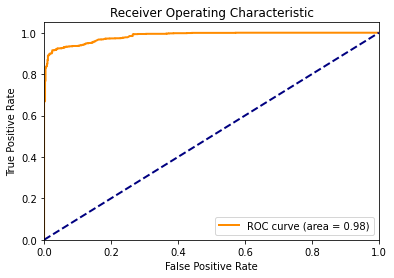

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

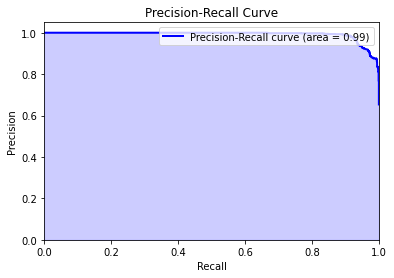

In [22]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train_transformed, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = rf_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
auc_roc = roc_auc_score(y_test, y_prob)
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

# Print the evaluation metrics
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest Recall: {rf_recall:.4f}")
print(f"Random Forest Precision: {rf_precision:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")
print(f'AUC-ROC: {auc_roc:.4f}')
print("Random Forest Confusion Matrix:")
print(rf_conf_matrix)

Random Forest Accuracy: 0.9272
Random Forest Recall: 0.9184
Random Forest Precision: 0.9686
Random Forest F1 Score: 0.9428
AUC-ROC: 0.9800
Random Forest Confusion Matrix:
[[ 656   39]
 [ 107 1204]]


### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_transformed, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test_transformed)

# Compute probabilities instead of binary predictions for AUC-ROC
y_prob = lr_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_recall = recall_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)
auc_roc = roc_auc_score(y_test, y_prob)
lr_conf_matrix = confusion_matrix(y_test, lr_predictions)

# Print the evaluation metrics
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression Recall: {lr_recall:.4f}")
print(f"Logistic Regression Precision: {lr_precision:.4f}")
print(f"Logistic Regression F1 Score: {lr_f1:.4f}")
print(f'AUC-ROC: {auc_roc:.4f}')
print("Logistic Regression Confusion Matrix:")
print(lr_conf_matrix)

Logistic Regression Accuracy: 0.9108
Logistic Regression Recall: 0.9390
Logistic Regression Precision: 0.9256
Logistic Regression F1 Score: 0.9322
AUC-ROC: 0.9525
Logistic Regression Confusion Matrix:
[[ 596   99]
 [  80 1231]]
